## Overview

The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states – called the Viterbi path – that results in a sequence of observed events, especially in the context of Markov information sources and hidden Markov models(more details [here](https://en.wikipedia.org/wiki/Viterbi_algorithm)). It is commonly used in tagging problems of NLP.

In this report, first I created a Viterbi algorithm with an example, then I applied the algorithm to do tagging on Brown Corpus to check how well it performs in terms of accuracy. 

## Introduction

Wikipedia has given a specific example and Python codes of Viterbi algorithm, which was created in Python dictionaries. In order to make the algorithm scalable, we used matrix to do computation in the key part of the algorithm. And we used an example of coding DNA from a [lecture note](http://homepages.ulb.ac.be/~dgonze/TEACHING/viterbi.pdf) shown below.

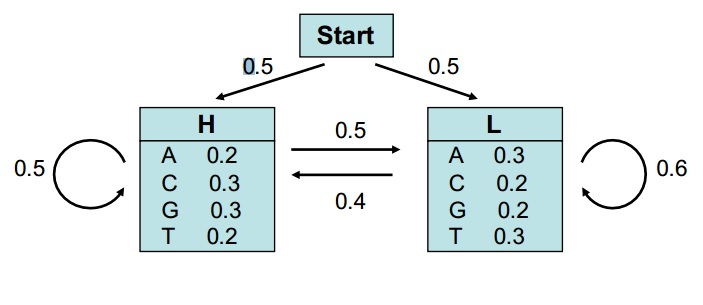

In [141]:
from IPython import display
display.Image('Viterbi.jpg')

In this example, there are two states H (high GC content) and L (low GC content), and four types of observations A, C, G, T. The transformation and emission probabilities are displayed in the graph, and we wrote them in the form of matrix.

In [142]:
import numpy as np
states_exa = ('H', 'L')
observations_exa = ('A', 'C', 'G', 'T')
start_p_exa = np.array([0.5, 0.5])
stop_p_exa = np.array([0.5, 0.5])
trans_p_exa = np.array([[0.5, 0.4], [0.5, 0.6]])#p(i, j) = p(i|j)
emit_p_exa = np.array([[0.3, 0.2], [0.3, 0.2], [0.3, 0.2], [0.2, 0.3], 
                       [0.3, 0.2], [0.2, 0.3], [0.3, 0.2],[0.2, 0.3], [0.2, 0.3]])#p(i, j) = p(i|j)

We divided the algorithm into three parts, the first one was the dynamic programming calculating the best probability and back point for each given observation and state. The second one was to find out the path leading to the max probability, and the last one was to display the final state series.

In [143]:
#Viteri Algorithm for Bigram HMM Model
#start_p: probability of start state
#trans_p: transition probabilities, matrix
#emit_p: emission probabilities, matrix
def BigramViterbi(start_p, trans_p, emit_p):
    try:
        y_len = trans_p.shape[0]
        x_len = emit_p.shape[0]
        pi = np.zeros([x_len+1, y_len+1])#maximum probability matrix for any sequence of length
        bp = np.zeros([x_len+1, y_len+1])#backpoint matrix
        #Base case
        pi[0, 0] = 1
        for i in range(1, y_len+1):
            pi[0, i] = 0
        #Find max probability
        for i in range(1, x_len+1):
            for j in range(1, y_len+1):
                if i == 1:#Find the max probability for pi(1, j)
                    pi[i, j] = start_p[j-1] * emit_p[i-1, j-1]
                else:
                    for l in range(y_len):
                        pi_new = pi[i-1, l+1] * trans_p[j-1, l] * emit_p[i-1, j-1]
                        if pi[i, j] < pi_new:
                            pi[i, j] = pi_new
                            bp[i, j] = l + 1
        return pi, bp
    except:
        print traceback.print_exc()  
        return None

In [144]:
#Find the index of state series with given pi and bp
#pi: max probability matrix for given observation index and state
#bp: backpoints corresponding to pi
def FindBestState(stop_p, pi, bp):
    try:
        x_len = pi.shape[0]
        y_len = pi.shape[1]
        max_prob = 0#max probability
        max_st = 0#the index of state which has the max probability 
        state_list = []
        #Find the max probability
        for j in range(1, y_len):
            prob = pi[x_len-1, j] * stop_p[j-1]
            if prob > max_prob:
                max_prob = prob
                max_st = j 
        state_list.append(max_st)
        #Find the max output states chain
        pre_st = max_st
        for i in range(x_len-1, 0, -1):
            pre_st = int(bp[i, pre_st])
            if i > 1: state_list.append(pre_st)
        #Reverse the order
        state_list.reverse()
        return state_list
    except:
        print traceback.print_exc()  
        return None

In [145]:
#Display the best state series 
def DisplayStates(states, index):
    state_series = []
    try:
        for i in index:
            state_series.append(states[i - 1])
        return state_series
    except:
        print traceback.print_exc()
        return None

In [146]:
pi_exa, bp_exa = BigramViterbi(start_p_exa, trans_p_exa, emit_p_exa)
st_indice = FindBestState(stop_p_exa, pi_exa, bp_exa)
DisplayStates(states_exa, st_indice)

['H', 'H', 'H', 'L', 'L', 'L', 'L', 'L', 'L']

It worked as expected, next we used the Viterbi algorithm to do tagging on Brown Corpus.

## Data Exploration

### Data Preprocess

We used the Brown Corpus downloaded by NLTK. The corpus has provided POS tags for the words and punctuation, so that we could use them to train our HMM model.

In [14]:
from nltk.corpus import brown
fileids = brown.fileids()
tagged_words = brown.tagged_words()
print 'Number of files:', len(fileids)
print 'Number of words:', len(tagged_words)

Number of files: 500
Number of words: 1161192


There are 500 files in the corpus, in order to validate our model, we need to split the data into training and testing parts. We randomly selected 300 articles as training and testing part.

In [15]:
import random
random.seed(100)
fileids_training = random.sample(fileids, 300)
fileids_testing = random.sample(fileids_training, 2)
for item in fileids_testing:
    fileids_training.remove(item) 

In [16]:
tagged_words_training = brown.tagged_words(fileids_training)
tagged_words_testing = brown.tagged_words(fileids_testing)
print 'Length of training words:', len(tagged_words_training)
print 'Length of testing words:', len(tagged_words_testing)

Length of training words: 692803
Length of testing words: 4722


In [17]:
from collections import Counter
words_training = [item[0] for item in tagged_words_training]
tags_training = [item[1] for item in tagged_words_training]
words_testing = [item[0] for item in tagged_words_testing]
tags_testing = [item[1] for item in tagged_words_testing]

### Words and Tags Analysis

In this part, we analysed the statistical characteristics of words and tags in Brown Corpus.

Number of unique words 42208


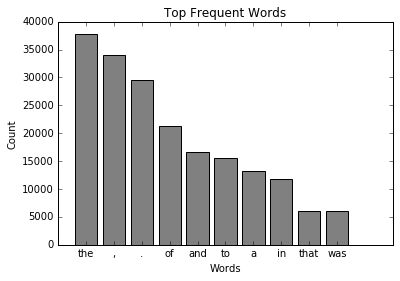

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline  
words_training_count = Counter(words_training)
print 'Number of unique words', len(words_training_count.keys())
#words_training_count.most_common(20)
left = range(1,11)
labels = [i for i,j in words_training_count.most_common(10)]
heights = [j for i,j in words_training_count.most_common(10)]
plt.bar(left=left,height=heights,tick_label=labels,align='center', color='grey')
plt.title('Top Frequent Words')
plt.xlabel('Words')
plt.ylabel('Count')

Undoubtedly, most frequent words are stop words and punctuation.

Number of different tags 427


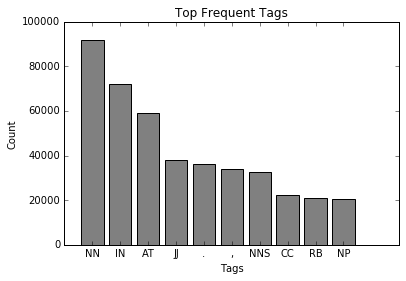

In [19]:
tags_training_count = Counter(tags_training)
print 'Number of different tags', len(tags_training_count.keys())
left = range(1,11)
labels = [i for i,j in tags_training_count.most_common(10)]
heights = [j for i,j in tags_training_count.most_common(10)]
plt.bar(left=left,height=heights,tick_label=labels,align='center', color='grey')
plt.title('Top Frequent Tags')
plt.xlabel('Tags')
plt.ylabel('Count')

There are only less than 500 unique tags. We need to check whether all the tags of testing data are within those of training data.

In [20]:
tags_testing_count = Counter(tags_testing)
print 'Number of different tags', len(tags_testing_count.keys())
new_tags = []
for key in tags_testing_count.keys():
    if key not in tags_training_count.keys():
        new_tags.append(key)
        print 'key', key, 'is not in training tags.'

Number of different tags 93


There are many new tags in the testing data. We could remove them so that all the tags of testing data would be within those of training data.

In [21]:
for word, tag in tagged_words_testing:
    if tag in new_tags:
        words_testing.remove(word)
        tags_testing.remove(tag)
print 'Length of Testing words:', len(words_testing)

Length of Testing words: 4722


It seems only dozens words and tags have been removed. 

In [22]:
words_testing_count = Counter(words_testing)
tags_testing_count = Counter(tags_testing)

In [23]:
unique_words_training = words_training_count.keys()
unknown_words_list = []
for word in words_testing_count.keys():
    if word in unique_words_training:
        unique_words_training.remove(word)
    else:
        unknown_words_list.append(word)
print 'Unknow words in the testing data:', len(unknown_words_list)

Unknow words in the testing data: 161


In [24]:
unknown_words_list[:10]

[u'familiarness',
 u'connects',
 u'cryptographic',
 u'semicircular',
 u'launch-control',
 u'glinted',
 u'forefingers',
 u'Starbird',
 u'speculatively',
 u'Unanimously']

In [25]:
unknown_words_freq = [words_testing_count[word] for word in unknown_words_list]
max(unknown_words_freq)
min(unknown_words_freq)

1

There should be many repetition of word and tag pairs.

Number of different tags 49954


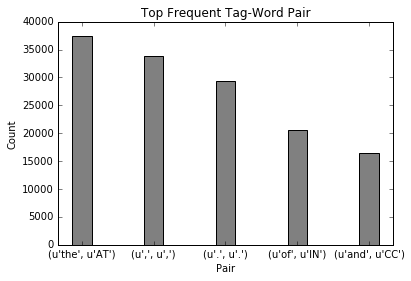

In [26]:
tag_word_freq = Counter(tagged_words_training)
print 'Number of different tags', len(tag_word_freq.keys())
left = range(3, 18, 3)
labels = [i for i,j in tag_word_freq.most_common(5)]
heights = [j for i,j in tag_word_freq.most_common(5)]
plt.bar(left=left,height=heights,tick_label=labels,align='center', color='grey')
plt.title('Top Frequent Tag-Word Pair')
plt.xlabel('Pair')
plt.ylabel('Count')

The pairs are corresponding to the distribution of words.

## Parameter Estimation

We considered **bigram model** here. We define c(u, s) to be the number of times the sequence of two states (u, s) is seen in training data.
Define c(s) to be the number of times that the state s is seen in the corpus. Finally, define c(s - x) to be the number of times state s is seen paired sith observation x in the corpus: for example, c(N - dog) would be the number of times the word dog is seen paired
with the tag N.

*q(s|u) = c(u, s)/c(u)*

*e(x|s) = c(s - x)/c(s)*

We need calculate the transition matrix *q* and emission matrix *e* based on the corpus mentioned above.

### Probabilities Calculation

We used Maximum-Likelihood method to estimate the distributions of unigram, bigram and trigram initially.

In [27]:
observations = words_training_count.keys()#Observations are words
states = tags_training_count.keys()#states are the tags
states_len = len(states)
obs_len = len(observations)

First, we calculated the frequencies of each tag and bigram tags in the training data.

In [28]:
unigram_freq = {}
for st in states:
    unigram_freq[st] = tags_training_count[st]

In [29]:
bigram_freq = dict()
for i in range(len(tags_training) - 1):
    u = tags_training[i]
    s = tags_training[i+1]
    bigram = (u, s)
    bigram_freq[bigram] = bigram_freq.get(bigram, 0) + 1

In [30]:
trigram_freq = dict()
for i in range(len(tags_training) - 2):
    u = tags_training[i]
    s = tags_training[i+1]
    v = tags_training[i+2]
    trigram = (u, s, v)
    trigram_freq[trigram] = trigram_freq.get(trigram, 0) + 1

Then, we could calculate the probabilities of each tag.

In [31]:
unigram_p = {}
for st in states:
    unigram_p[st] = float(tags_training_count[st])/states_len

Next, calculate the probabilities of bigram tags.

In [32]:
bigram_p = {}
for k, v in bigram_freq.items():
    #print k, v
    if unigram_freq[k[0]] != 0:
        bigram_p[k] = float(v)/unigram_freq[k[0]]#p(yi|yi-1)
    else:
        bigram_p[k] = 0

Also, we calculated th probabilities of trigram tag.

In [33]:
trigram_p = {}
for k, v in trigram_freq.items():
    #print k, v
    if bigram_freq[k[:2]] != 0:
        trigram_p[k] = float(v)/bigram_freq[k[:2]]#p(yi|yi-1)
    else:
        trigram_p[k] = 0

Next, we calculated the condition probabilities between the tags and the words.

In [34]:
tag_word_freq = Counter(tagged_words_training)
len(tag_word_freq)

49954

In [35]:
tag_word_p = {}
for k, v in tag_word_freq.items():
    if unigram_freq[k[1]] != 0:
        tag_word_p[k] = float(v)/unigram_freq[k[1]]#p(xi|yi)
    else:
        tag_word_p[k] = 0

We need to transform the dictionaries into matrix for latter algorithms. 

### Transformation and Emission Matrix of Testing Data

In order to run HMM algorithms, we need calculate the transformation and emission matrix.

In [85]:
import numpy as np
observations_testing = words_testing
obs_len_testing = len(words_testing)
trans_p = np.zeros([states_len, states_len])#there are 421 unique tags
trans_p_testing = np.zeros([states_len, states_len])#there are 421 unique tags
emit_p = np.zeros([obs_len, states_len])#there are 45060 unique words and punctuation
start_p = np.zeros(states_len)#probabilities of each tag
emit_p_testing = np.zeros([obs_len_testing, states_len])

First, we could get the probabilities of each tag, namely the start probability.

In [93]:
i = 0
for st in states:
    start_p[i] = unigram_p[st]
    i = i + 1

Next, calculated the transformation matrix. Here, we considered *bigram case*.

In [38]:
for k, v in bigram_p.items():
    s0, s1 = k[0], k[1]
    i = states.index(s0)
    j = states.index(s1)
    trans_p[i, j] = v

In [39]:
trans_p

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00063412,  0.01077996, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

There are many zeros in the transformation matrix. Next, calculated the emission matrix. ** Note: there are unknown words in the testing data as we discussed above. ** 

In [40]:
for k, v in tag_word_p.items():
    o, s = k[0], k[1]
    if o in observations_testing:
        i = observations_testing.index(o)
        j = states.index(s)
        emit_p_testing[i, j] = v

In [41]:
emit_p_testing

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Obviously,** trans_p and emit_p are sparse matrix. Many of the above estimates will be q(w|u) = 0, due to the count in the numerator being 0**. This will lead to many bigram, trigram probabilities being systematically underestimated: it seems unreasonable to assign probability 0 to any trigram not seen in training data. To solve the problem, we can adopt soothed estimation methods such as Laplace smoothing or linear interpolation or discount method.

### Smoothed Estimation

Here, we introduced a Laplace method as described in the [lecture note](http://stp.lingfil.uu.se/~nivre/statmet/haulrich.pdf). Allowing for the compuational capability, we would use ** Hash method to do search **.

In [43]:
pairs = tag_word_p.keys()
pairs_hash_by_tag = {}
for st in states:
    pairs_hash_by_tag[st] = []
for pair in pairs:
    st = pair[1]
    pairs_hash_by_tag[st].append(pair)

In [44]:
lens_of_hash_pairs = [len(v) for v in pairs_hash_by_tag.values()]
np.mean(lens_of_hash_pairs)

116.98829039812647

In [127]:
for i in range(obs_len_testing):
    for j in range(states_len):
        o = observations_testing[i]
        s = states[j]
        t = (o, s)
        if t in pairs_hash_by_tag[s]:
            emit_p_testing[i, j] = (tag_word_freq[t] + 1.0)/(unigram_freq[s] + obs_len_testing)
        else:
            emit_p_testing[i, j] = 1.0 /(unigram_freq[s] + obs_len_testing)        

In [128]:
for k, v in bigram_freq.items():
    i = states.index(k[0])
    j = states.index(k[1])
    trans_p_testing[j, i] = (v + 1.0) / (unigram_freq[k[0]] + states_len)

In [129]:
for i in range(states_len):
    for j in range(states_len):
        o1 = states[i]
        o2 = states[j]
        if trans_p_testing[i, j] == 0:
            trans_p_testing[i, j] = 1.0 /(unigram_freq[o2] + states_len)        

In [130]:
trans_p_testing

array([[ 0.00229885,  0.000499  ,  0.00114811, ...,  0.00231481,
         0.00166667,  0.0022779 ],
       [ 0.00229885,  0.000998  ,  0.00114811, ...,  0.00231481,
         0.00166667,  0.0022779 ],
       [ 0.00229885,  0.00898204,  0.00114811, ...,  0.00231481,
         0.00166667,  0.0022779 ],
       ..., 
       [ 0.00229885,  0.000499  ,  0.00114811, ...,  0.00231481,
         0.00166667,  0.0022779 ],
       [ 0.00229885,  0.000499  ,  0.00114811, ...,  0.00231481,
         0.00166667,  0.0022779 ],
       [ 0.00229885,  0.000499  ,  0.00114811, ...,  0.00231481,
         0.00166667,  0.0022779 ]])

In [131]:
emit_p_testing

array([[ 0.00021142,  0.00015876,  0.00019357, ...,  0.00021155,
         0.00020429,  0.00021124],
       [ 0.00190275,  0.00015876,  0.00019357, ...,  0.00021155,
         0.00020429,  0.00021124],
       [ 0.00021142,  0.00015876,  0.00019357, ...,  0.00021155,
         0.00020429,  0.00021124],
       ..., 
       [ 0.00021142,  0.00015876,  0.00019357, ...,  0.00021155,
         0.00020429,  0.00021124],
       [ 0.00021142,  0.00015876,  0.00019357, ...,  0.00021155,
         0.00020429,  0.00021124],
       [ 0.00021142,  0.00015876,  0.00019357, ...,  0.00021155,
         0.00020429,  0.00021124]])

## Viterbi Algorithm for Bigram Model

We applied Viterbi algorithm to this corpus, **Note: there probabilities are very small, if we multiply them again and again,  the final value would be too small that the system may regard it as zero.** Therefore, we used **log transformation** in the algorithm, and replaced the multiply with addition.

In [133]:
import math
import traceback
#Viteri Algorithm for Bigram HMM Model
#start_p: probability of start state
#trans_p: transition probabilities, matrix
#emit_p: emission probabilities, matrix
def BigramViterbi(start_p, trans_p, emit_p):
    try:
        y_len = trans_p.shape[0]
        x_len = emit_p.shape[0]
        pi = np.zeros([x_len+1, y_len+1])#maximum probability matrix for any sequence of length
        bp = np.zeros([x_len+1, y_len+1])#backpoint matrix
        #Base case
        pi[0, 0] = 0
        for i in range(1, y_len+1):
            pi[0, i] = -float('Inf')#negative infinity
        #Find max probability
        for i in range(1, x_len+1):
            for j in range(1, y_len+1):
                pi[i, j] = -float('Inf')
                emit_log = math.log(emit_p[i-1, j-1])
                if i == 1:#Find the max porbability for pi(1, j)
                    pi[i, j] = math.log(start_p[j-1]) + emit_log
                else:
                    for l in range(y_len):
                        pi_new = pi[i-1, l+1] + math.log(trans_p[j-1, l]) + emit_log
                        if pi[i, j] < pi_new:
                            pi[i, j] = pi_new
                            bp[i, j] = l + 1
        return pi, bp
    except:
        print traceback.print_exc()  
        return None

def FindBestState(stop_p, pi, bp):
    try:
        x_len = pi.shape[0]
        y_len = pi.shape[1]
        max_prob = -float('Inf')#max probability
        max_st = 0#the index of state which has the max probability 
        state_list = []
        #Find the max probability
        for j in range(1, y_len):
            prob = pi[x_len-1, j] + math.log(stop_p[j-1])
            if prob > max_prob:
                max_prob = prob
                max_st = j 
        state_list.append(max_st)
        #Find the max output states chain
        pre_st = max_st
        for i in range(x_len-1, 0, -1):
            pre_st = int(bp[i, pre_st])
            if i > 1: state_list.append(pre_st)
        state_list.reverse()
        return state_list
    except:
        print traceback.print_exc()  
        return None        

In [134]:
pi, bp = BigramViterbi(start_p, trans_p_testing, emit_p_testing)

In [136]:
stop_p_testing = np.ones([states_len])
tags_index = FindBestState(stop_p_testing, pi, bp)
tag_correct_count = 0
for i in range(obs_len_testing):
    if tags_testing[i] ==  states[tags_index[i] - 1]:
        tag_correct_count = tag_correct_count + 1
print 'Accuracy is:', tag_correct_count * 1.0/obs_len_testing    

Accuracy is: 0.886912325286


The Viterbi algorithm predicted more than 88 percent of the tags in the testing data.

## Imporvement

In our further work, we planned to use linear interpolation and discount methods to do parameter estimation and make comparisons of performances of these methods. In addition, we could use trigram model to improve the accuracy of tagging.